In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_graph(bars, labels, title):
    """
    Plota gráficos de barras lado a lado.

    Args:
        bars (list): Lista de vetores com os valores das barras.
        labels (list): Lista de rótulos para as barras.
        title (str): Título do gráfico.
    """
    # Número de barras e rótulos
    num_bars = len(bars)
    num_labels = len(labels)

    # Verificar se o número de barras e rótulos é o mesmo
    if num_bars != num_labels:
        raise ValueError("O número de barras deve ser igual ao número de rótulos.")

    # Rótulos para as barras
    r = np.arange(len(bars[0]))

    # Largura das barras
    bar_width = 1 / (num_bars + 1)

    # Cores para as barras
    colors = ['red', 'green', 'blue', 'yellow', 'orange']

    # Monta o gráfico de barras
    for i in range(num_labels):
        plt.bar(r + i * bar_width, bars[i], color=colors[i], width=bar_width,
                edgecolor='white', label=labels[i])

    # Adicionar rótulos, título e legenda ao gráfico
    plt.xlabel('Operações CRUD')
    plt.ylabel('Valores')
    plt.title(title)
    plt.xticks(r + (num_bars - 1) * bar_width / 2, ['Insert', 'Read', 'Update', 'Delete'])
    plt.legend()

    plt.show()


In [11]:
import pandas as pd
import re

# Definindo a função para processar o texto em DataFrame
def process_benchmark_data(text):
    data = []
    current_class = None

    # Percorre cada linha do texto
    for line in text.splitlines():
        # Verifica se é uma linha de título de classe
        if line.startswith('Class'):
            current_class = line.strip()
        else:
            # Extrai os dados usando regex
            match = re.match(r'Benchmark(\w+)-\d+\s+(\d+)\s+(\d+) ns/op\s+(\d+) B/op\s+(\d+) allocs/op', line)
            if match:
                operation = match.group(1)
                ops = int(match.group(2))
                ns_per_op = int(match.group(3))
                b_per_op = int(match.group(4))
                allocs_per_op = int(match.group(5))
                data.append([current_class, operation, ops, ns_per_op, b_per_op, allocs_per_op])
    
    # Cria o DataFrame
    df = pd.DataFrame(data, columns=['methodology', 'operation', 'ops', 'time_per_op', 'bytes_per_op', 'allocs_per_op'])
    
    # Agrupa os dados pela metodologia e operação, calculando a média
    grouped_summary = df.groupby(['methodology', 'operation']).mean().reset_index()
    return grouped_summary

In [12]:
# Dados obtidos dos testes
benchmark_text = """
ClassWithGorm
BenchmarkInsertClass-8   	     199	   7542333 ns/op	   12069 B/op	     164 allocs/op
BenchmarkReadClass-8     	     298	   4154921 ns/op	   51744 B/op	     955 allocs/op
BenchmarkUpdateClass-8   	     430	   3024380 ns/op	    6334 B/op	      79 allocs/op
BenchmarkDeleteClass-8   	     198	   6154034 ns/op	   11916 B/op	     163 allocs/op
BenchmarkInsertClass-8   	     171	   9376897 ns/op	   12291 B/op	     165 allocs/op
BenchmarkReadClass-8     	     188	   6620905 ns/op	   51794 B/op	     957 allocs/op
BenchmarkUpdateClass-8   	     246	   4400832 ns/op	    6337 B/op	      79 allocs/op
BenchmarkDeleteClass-8   	     117	   8940160 ns/op	   12215 B/op	     166 allocs/op
BenchmarkInsertClass-8   	     123	   8879320 ns/op	   12360 B/op	     167 allocs/op
BenchmarkReadClass-8     	     196	   5753415 ns/op	   51777 B/op	     957 allocs/op
BenchmarkUpdateClass-8   	     284	   4416036 ns/op	    6341 B/op	      79 allocs/op
BenchmarkDeleteClass-8   	     136	   8255049 ns/op	   12106 B/op	     164 allocs/op

ClassOneQuery
BenchmarkInsertClass-8   	     243	   4972132 ns/op	    1433 B/op	      34 allocs/op
BenchmarkReadClass-8     	     660	   1876615 ns/op	   11064 B/op	     517 allocs/op
BenchmarkUpdateClass-8   	     583	   2207321 ns/op	     415 B/op	      13 allocs/op
BenchmarkDeleteClass-8   	     254	   4440355 ns/op	    1401 B/op	      33 allocs/op
BenchmarkInsertClass-8   	     276	   4039455 ns/op	    1395 B/op	      34 allocs/op
BenchmarkReadClass-8     	     771	   1436036 ns/op	   11066 B/op	     517 allocs/op
BenchmarkUpdateClass-8   	     610	   1878278 ns/op	     414 B/op	      13 allocs/op
BenchmarkDeleteClass-8   	     318	   3658434 ns/op	    1338 B/op	      33 allocs/op
BenchmarkInsertClass-8   	     168	   6988435 ns/op	    1576 B/op	      35 allocs/op
BenchmarkReadClass-8     	     387	   3240193 ns/op	   11064 B/op	     517 allocs/op
BenchmarkUpdateClass-8   	     334	   3143764 ns/op	     414 B/op	      13 allocs/op
BenchmarkDeleteClass-8   	     171	   6813502 ns/op	    1539 B/op	      34 allocs/op

ClassDAO
BenchmarkInsertClass-8   	     279	   5442560 ns/op	    1838 B/op	      51 allocs/op
BenchmarkReadClass-8     	      96	  12052747 ns/op	   18664 B/op	     491 allocs/op
BenchmarkUpdateClass-8   	     607	   4206338 ns/op	     624 B/op	      24 allocs/op
BenchmarkDeleteClass-8   	     243	   4931366 ns/op	    1882 B/op	      51 allocs/op
BenchmarkInsertClass-8   	     264	   4090645 ns/op	    1859 B/op	      51 allocs/op
BenchmarkReadClass-8     	     100	  10449300 ns/op	   18668 B/op	     491 allocs/op
BenchmarkUpdateClass-8   	     688	   1950633 ns/op	     624 B/op	      24 allocs/op
BenchmarkDeleteClass-8   	     288	   3741001 ns/op	    1832 B/op	      51 allocs/op
BenchmarkInsertClass-8   	     165	   7269721 ns/op	    2036 B/op	      52 allocs/op
BenchmarkReadClass-8     	      82	  15597262 ns/op	   18661 B/op	     491 allocs/op
BenchmarkUpdateClass-8   	     384	   3323391 ns/op	     625 B/op	      24 allocs/op
BenchmarkDeleteClass-8   	     178	   6443615 ns/op	    1995 B/op	      52 allocs/op
"""

In [13]:
from tabulate import tabulate
# Processando os dados
grouped_summary = process_benchmark_data(benchmark_text)
print(tabulate(grouped_summary, headers='keys', tablefmt='pretty'))

+----+---------------+-------------+--------------------+--------------------+--------------------+--------------------+
|    |  methodology  |  operation  |        ops         |    time_per_op     |    bytes_per_op    |   allocs_per_op    |
+----+---------------+-------------+--------------------+--------------------+--------------------+--------------------+
| 0  |   ClassDAO    | DeleteClass | 236.33333333333334 | 5038660.666666667  |       1903.0       | 51.333333333333336 |
| 1  |   ClassDAO    | InsertClass |       236.0        | 5600975.333333333  |       1911.0       | 51.333333333333336 |
| 2  |   ClassDAO    |  ReadClass  | 92.66666666666667  | 12699769.666666666 | 18664.333333333332 |       491.0        |
| 3  |   ClassDAO    | UpdateClass | 559.6666666666666  | 3160120.6666666665 | 624.3333333333334  |        24.0        |
| 4  | ClassOneQuery | DeleteClass | 247.66666666666666 | 4970763.666666667  |       1426.0       | 33.333333333333336 |
| 5  | ClassOneQuery | InsertCla

In [14]:
# Função para extrair dados e evitar arrays vazios
def extract_data(df, class_name, attribute_benchmark):
    insert = df[(df['methodology'] == class_name) & (df['operation'] == 'InsertClass')][attribute_benchmark].values
    read = df[(df['methodology'] == class_name) & (df['operation'] == 'ReadClass')][attribute_benchmark].values
    update = df[(df['methodology'] == class_name) & (df['operation'] == 'UpdateClass')][attribute_benchmark].values
    delete = df[(df['methodology'] == class_name) & (df['operation'] == 'DeleteClass')][attribute_benchmark].values
    return [np.mean(insert) if insert.size > 0 else np.nan,
            np.mean(read) if read.size > 0 else np.nan,
            np.mean(update) if update.size > 0 else np.nan,
            np.mean(delete) if delete.size > 0 else np.nan]

In [15]:
def plot_per(attribute_benchmark):
    # Extraindo os dados para o gráfico
    insert_dao, read_dao, update_dao, delete_dao = extract_data(grouped_summary, 'ClassDAO', attribute_benchmark)
    insert_onequery, read_onequery, update_onequery, delete_onequery = extract_data(grouped_summary, 'ClassOneQuery', attribute_benchmark)
    insert_gorm, read_gorm, update_gorm, delete_gorm = extract_data(grouped_summary, 'ClassWithGorm', attribute_benchmark)

    # Dados para o gráfico
    bars = [
        [insert_dao, read_dao, update_dao, delete_dao],
        [insert_onequery, read_onequery, update_onequery, delete_onequery],
        [insert_gorm, read_gorm, update_gorm, delete_gorm]
    ]

    labels = ['DAO', 'OneQuery', 'GORM']
    title = 'Benchmark CRUD ' + attribute_benchmark

    # Plotar o gráfico
    plot_bar_graph(bars, labels, title)

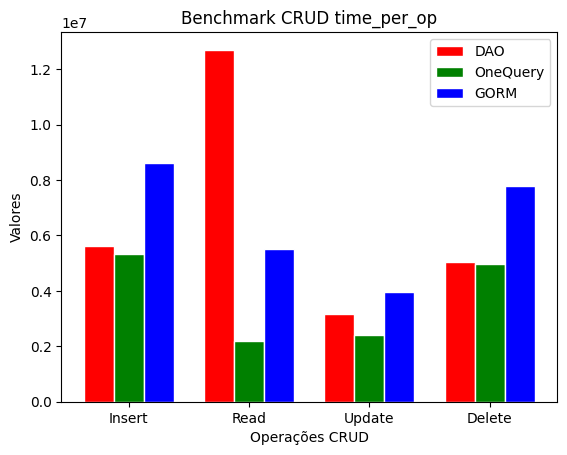

In [16]:
plot_per('time_per_op')

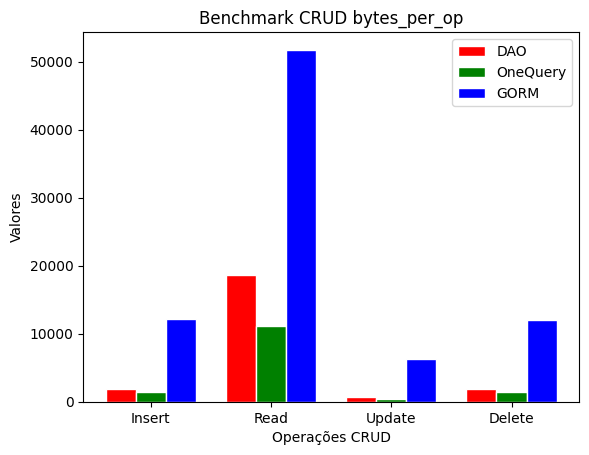

In [17]:
plot_per('bytes_per_op')

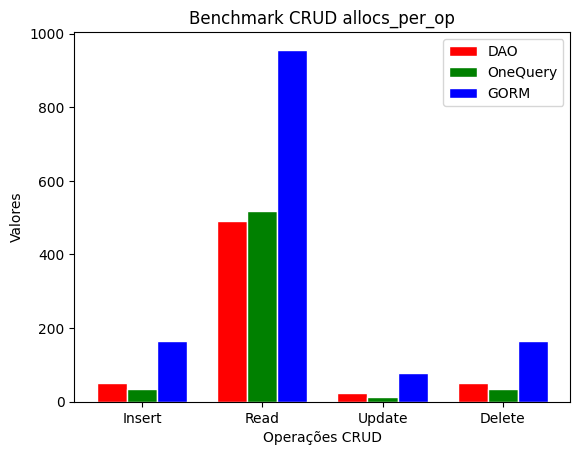

In [18]:
plot_per('allocs_per_op')